# Распознавание текста

## CRNN+CTC loss baseline

В данном ноутбуке представлен baseline модели распознавания текста с помощью CRNN модели и CTC loss. Вы можете добавить новые аугментации или изменить структуру данной модели, или же попробовать совершенно новую архитектуру.

# 0. Установка и подгрузука библиотек

Установка библиотек, под которым запускается данный бейзлайн.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install numpy==1.20.3
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install opencv-python==4.5.2.52
!pip install matplotlib==3.4.2

     |████████████████████████████████| 15.3 MB 442 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Uninstalling numpy-1.21.5:
      Successfully uninstalled numpy-1.21.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.3 MB/s eta 0:15:55tcmalloc: large alloc 1147494400 bytes == 0x55c6e7a14000 @  0x7fc44419a615 0x55c6ae3993bc 0x55c6ae47a18a 0x55c6ae39c1cd 0x55c6ae48eb3d 0x55c6ae410458 0x55c6ae40b02f 0x55c6ae39daba 0x55c6ae4102c0 0x55c6ae40b02f 0x55c6ae39daba 0x55c6ae40ccd4 0x55c6ae48f986 0x55c6ae40c350 0x55c6ae48f986 0x55c6ae40c350 0x55c6ae48f986 0x55c6ae40c350 0x55c6ae39df19 0x55c6ae3e1a79 0x55c6ae39cb32 0x55c6ae4101dd 0x55c6ae40b02f 0x55c6ae39daba 0x55c6ae40ccd4 0x55c6ae40b02f 0x55c6ae39daba 0x55c6ae40beae 0x55c6ae39d9da 0x55c6ae40c108 0x55c6ae40b02f
     |████████████████▌               | 1055.7 MB 1.3 MB/s eta 0:12:57tcmalloc: large alloc 1434370048 bytes == 0x55c72c06a000 @  0x7fc44419a615 0x55c6ae3993bc 0x55c6ae47a18a 0x55c6ae39c1cd 0x55c6ae48eb3d 0x55c6ae410458 0x55c6ae40b02f 0x55c6ae39daba 0x55c6ae4102c0 0x55c6ae40b02f 0x55c6ae39daba 0x55c6ae40ccd4 0x55c6ae48f986 0x55c6ae40c3

In [2]:
!pip uninstall opencv-python -y
!pip install opencv-python==4.5.2.52
import cv2

Found existing installation: opencv-python 4.5.2.52
Uninstalling opencv-python-4.5.2.52:
  Successfully uninstalled opencv-python-4.5.2.52
  Using cached opencv_python-4.5.2.52-cp37-cp37m-manylinux2014_x86_64.whl (51.0 MB)


In [3]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

import numpy as np
import cv2
import os
import json
from PIL import Image
from matplotlib import pyplot as plt

## 1. Разделим трейн датасет на обучающую и валидационную подвыборки


Сначала преобразуем таблицу (в которой есть колонка base_image) в `labels.json` - это формат из второго этапа олимпиады, для которого составлялся бейзлайн. По сути это просто словарь из колонок 'file_name' и 'text'.

In [4]:
import pandas as pd

In [5]:
train_csv = pd.read_csv('/content/drive/MyDrive/data/train_recognition/labels.csv')
train_csv = train_csv.sample(frac = 1)

train_data = dict(train_csv[['file_name','text']].values)


In [6]:
train_data = [(k, v) for k, v in train_data.items()]
print('train len', len(train_data))

split_coef = 0.75
train_len = int(len(train_data)*split_coef)

train_data_splitted = train_data[:train_len]
val_data_splitted = train_data[train_len:]

print('train len after split', len(train_data_splitted))
print('val len after split', len(val_data_splitted))

train len 161700
train len after split 121275
val len after split 40425


In [7]:
with open('/content/drive/MyDrive/data/train_recognition/train_labels_splitted.json', 'w') as f:
    json.dump(dict(train_data_splitted), f)
    
with open('/content/drive/MyDrive/data/train_recognition/val_labels_splitted.json', 'w') as f:
    json.dump(dict(val_data_splitted), f)

## 2. Зададим параметры обучения

Здесь мы можем поправить конфиги обучения - задать размер батча, количество эпох, размер входных изображений, а также установить пути к датасетам.

In [8]:
alphabet = ''.join(sorted(list(set(''.join(train_csv['text'].values)))))

In [9]:
alphabet

' !"%\'()*+,-./0123456789:;<=>?ABCDEFGHIJKLMNOPRSTUVWXY[]_abcdefghijklmnopqrstuvwxyz|}ЁАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЩЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№'

In [10]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


config_json = {
    "alphabet": ''' !"%\'()*+,-./0123456789:;<=>?ABCDEFGHIJKLMNOPRSTUVWXY[]_abcdefghijklmnopqrstuvwxyz|}ЁАБВГДЕЖЗИКЛМНОПРСТУФХЦЧШЩЫЬЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяё№''',
    "save_dir": "/content/drive/MyDrive/data/experiments/test",
    "num_epochs": 100,
    "image": {
        "width": 256,
        "height": 64
    },
    "train": {
        "root_path": "/content/drive/MyDrive/data/train_recognition/images",
        "json_path": "/content/drive/MyDrive/data/train_recognition/train_labels_splitted.json",
        "batch_size": 256
    },
    "val": {
        "root_path": "/content/drive/MyDrive/data/train_recognition/images",
        "json_path": "/content/drive/MyDrive/data/train_recognition/val_labels_splitted.json",
        "batch_size": 128
    }
}

In [9]:
# with open(config_json['train']['json_path']) as json_file:
#     data = json.load(json_file)
# images = list(data.keys())
# image = cv2.imread(f"{config_json['train']['root_path']}/{images[randint(0, len(images))]}")
# plt.imshow(image)
# plt.show()

In [11]:
DEVICE

device(type='cuda')

## 3. Теперь определим класс датасета (torch.utils.data.Dataset) и другие вспомогательные функции

In [12]:
# функция которая помогает объединять картинки и таргет-текст в батч
def collate_fn(batch):
    images, texts, enc_texts = zip(*batch)
    images = torch.stack(images, 0)
    text_lens = torch.LongTensor([len(text) for text in texts])
    enc_pad_texts = pad_sequence(enc_texts, batch_first=True, padding_value=0)
    return images, texts, enc_pad_texts, text_lens


def get_data_loader(
    transforms, json_path, root_path, tokenizer, batch_size, drop_last
):
    dataset = OCRDataset(json_path, root_path, tokenizer, transforms)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        collate_fn=collate_fn,
        batch_size=batch_size,
        num_workers=8,
    )
    return data_loader


class OCRDataset(Dataset):
    def __init__(self, json_path, root_path, tokenizer, transform=None):
        super().__init__()
        self.transform = transform
        with open(json_path, 'r') as f:
            data = json.load(f)
        self.data_len = len(data)

        self.img_paths = []
        self.texts = []
        for img_name, text in data.items():
            self.img_paths.append(os.path.join(root_path, img_name))
            self.texts.append(text)
        self.enc_texts = tokenizer.encode(self.texts)

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        text = self.texts[idx]
        enc_text = torch.LongTensor(self.enc_texts[idx])
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            image = self.transform(image=image)['image']
            
        return image, text, enc_text


class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## 4. Здесь определен Токенайзер - вспопогательный класс, который преобразует текст в числа

Разметка-текст с картинок преобразуется в числовое представление, на которых модель может учиться. Также может преобразовывать числовое предсказание модели обратно в текст.

In [47]:
OOV_TOKEN = '<OOV>'
CTC_BLANK = '<BLANK>'


def get_char_map(alphabet):
    """Make from string alphabet character2int dict.
    Add BLANK char fro CTC loss and OOV char for out of vocabulary symbols."""
    char_map = {value: idx + 2 for (idx, value) in enumerate(alphabet)}
    char_map[CTC_BLANK] = 0
    char_map[OOV_TOKEN] = 1
    return char_map


class Tokenizer:
    """Class for encoding and decoding string word to sequence of int
    (and vice versa) using alphabet."""

    def __init__(self, alphabet):
        self.char_map = get_char_map(alphabet)
        self.rev_char_map = {val: key for key, val in self.char_map.items()}

    def encode(self, word_list):
        """Returns a list of encoded words (int)."""
        enc_words = []
        for word in word_list:
            enc_words.append(
                [self.char_map[char] if char in self.char_map
                 else self.char_map[OOV_TOKEN]
                 for char in word]
            )
        return enc_words

    def get_num_chars(self):
        return len(self.char_map)

    def decode(self, enc_word_list):
        """Returns a list of words (str) after removing blanks and collapsing
        repeating characters. Also skip out of vocabulary token."""
        dec_words = []
        for word in enc_word_list:
            word_chars = ''
            for idx, char_enc in enumerate(word):
                # skip if blank symbol, oov token or repeated characters
                if (
                    char_enc != self.char_map[OOV_TOKEN]
                    and char_enc != self.char_map[CTC_BLANK]
                    # idx > 0 to avoid selecting [-1] item
                    and not (idx > 0 and char_enc == word[idx - 1])
                ):
                    word_chars += self.rev_char_map[char_enc]
            dec_words.append(word_chars)
        return dec_words

## 5. Accuracy в качестве метрики

Accuracy измеряет долю предсказанных строк текста, которые полностью совпадают с таргет текстом.

In [14]:
def get_accuracy(y_true, y_pred):
    scores = []
    for true, pred in zip(y_true, y_pred):
        scores.append(true == pred)
    avg_score = np.mean(scores)
    return avg_score

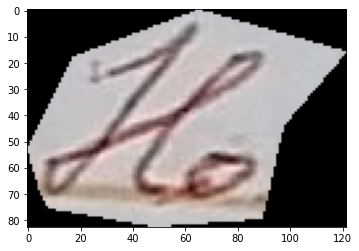

In [46]:
img = cv2.imread("/content/drive/MyDrive/data/train_recognition/images/137944.png")
plt.imshow(img)
plt.show()

## 6. Аугментации

Здесь мы задаем базовые аугментации для модели. Вы можете написать свои или использовать готовые библиотеки типа albumentations

In [15]:
!pip uninstall albumentations -y

Found existing installation: albumentations 0.1.12
Uninstalling albumentations-0.1.12:
  Successfully uninstalled albumentations-0.1.12


In [16]:
!pip install albumentations

     |████████████████████████████████| 102 kB 9.9 MB/s 
     |████████████████████████████████| 47.7 MB 1.9 MB/s 


/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1828: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


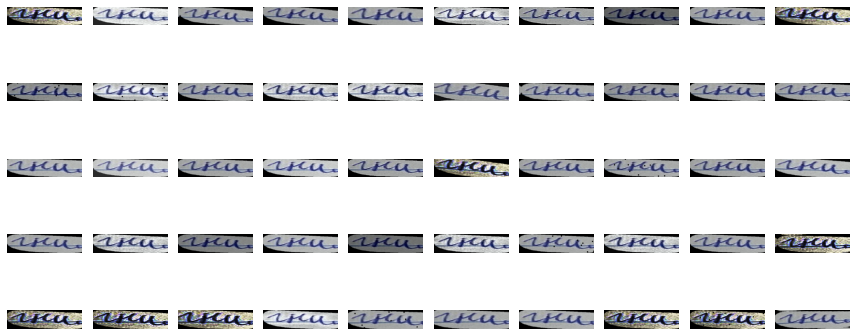

In [16]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
#from albumentations.pytorch.transforms import ToTensorV2

import random
import copy

height = config_json['image']['height']
width = config_json['image']['width']

class ToTensor:
    def __call__(self, arr):
        arr = torch.from_numpy(arr)
        return arr

class Normalize:
    def __call__(self, image):
        image = image.astype(np.float32) / 255
        return image


class MoveChannels:
    """Move the channel axis to the zero position as required in pytorch."""
    def __init__(self, to_channels_first=True):
        self.to_channels_first = to_channels_first

    def __call__(self, image):
        if self.to_channels_first:
            return np.moveaxis(image, -1, 0)
        else:
            return np.moveaxis(image, 0, -1)


train_transform = A.Compose([
    A.augmentations.geometric.resize.Resize(height, width),
    # MoveChannels(to_channels_first=True),
    A.Perspective(scale=(0.025, 0.075), p=0.1),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.05, rotate_limit=[-5, 5], p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomContrast(p=0.2),
    A.CLAHE(p=0.2),
    A.Cutout(num_holes=10, max_h_size=4, max_w_size=4, fill_value=0, p=0.1),
    A.Downscale(scale_min=0.9, scale_max=0.99,p=0.1),
    A.Equalize(p=0.2),
    A.Sharpen(alpha=(0.1, 0.4), lightness=(0.75, 1.0), p=0.2),
    A.Normalize(mean=0, std=1),
    ToTensorV2(),
])

train_dataset = OCRDataset(json_path=config_json['train']['json_path'],
                           root_path=config_json['train']['root_path'],
                           tokenizer=Tokenizer(config_json['alphabet']),
                           transform=train_transform)



val_transform = A.Compose([
        A.augmentations.geometric.resize.Resize(height, width),
        A.Normalize(mean=0, std=1),
        ToTensorV2(),
    ])



val_dataset = OCRDataset(json_path=config_json['val']['json_path'],
                           root_path=config_json['val']['root_path'],
                           tokenizer=Tokenizer(config_json['alphabet']),
                           transform=val_transform)

def visualize_augmentations(dataset, idx=0, samples=50, cols=10):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image= dataset[idx][0]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()
    
visualize_augmentations(train_dataset)


def get_train_transforms(height, width):
    transform = A.Compose([
    A.augmentations.geometric.resize.Resize(height, width),
    # MoveChannels(to_channels_first=True),
    A.Perspective(scale=(0.025, 0.075), p=0.1),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.05, rotate_limit=[-5, 5], p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomContrast(p=0.2),
    A.CLAHE(p=0.2),
    A.Cutout(num_holes=10, max_h_size=4, max_w_size=4, fill_value=0, p=0.1),
    A.Downscale(scale_min=0.9, scale_max=0.99,p=0.1),
    A.Equalize(p=0.2),
    A.Sharpen(alpha=(0.1, 0.4), lightness=(0.75, 1.0), p=0.2),
    A.Normalize(mean=0, std=1),
    ToTensorV2(),
])
    return transform





def get_val_transforms(height, width):
    transforms = A.Compose([
        A.augmentations.geometric.resize.Resize(height, width),
        A.Normalize(),
        ToTensorV2(),
    ])
    return transforms

## 7. Здесь определяем саму модель - CRNN

Подробнее об архитектуре можно почитать в статье https://arxiv.org/abs/1507.05717

In [43]:
def get_resnet34_backbone(pretrained=True):
    m = torchvision.models.resnet34(pretrained=True)
    input_conv = nn.Conv2d(3, 64, 7, 1, 3)
    blocks = [input_conv, m.bn1, m.relu,
              m.maxpool, m.layer1, m.layer2, m.layer3]
    return nn.Sequential(*blocks)


class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.15):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers,
            dropout=dropout, batch_first=True, bidirectional=True)

    def forward(self, x):
        out, _ = self.lstm(x)
        return out


class CRNN(nn.Module):
    def __init__(
        self, number_class_symbols, time_feature_count=256, lstm_hidden=256,
        lstm_len=2,
    ):
        super().__init__()
        self.feature_extractor = get_resnet34_backbone(pretrained=True)
        self.avg_pool = nn.AdaptiveAvgPool2d(
            (time_feature_count, time_feature_count))
        self.bilstm = BiLSTM(time_feature_count, lstm_hidden, lstm_len)
        self.classifier = nn.Sequential(
            nn.Linear(lstm_hidden * 2, time_feature_count),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(time_feature_count, number_class_symbols),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        b, c, h, w = x.size()
        x = x.view(b, c * h, w)
        x = self.avg_pool(x)
        x = x.transpose(1, 2)
        x = self.bilstm(x)
        x = self.classifier(x)
        x = nn.functional.log_softmax(x, dim=2).permute(1, 0, 2)
        return x

## Логирование лол

In [ ]:
!pip uninstall neptune-client -y
!pip install neptune-client

In [18]:
# Я тут логирование запилю, на всякий

import neptune.new as neptune

run = neptune.init(
    project="temiusiii/OCR-NTO",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5NzBkMWVlMC1hMmI3LTQ3NDAtOTJjNy00NGMxOThhZTcyNWEifQ==",
)  # your credentials

params = {
    "alphabet": config_json['alphabet'],
    "image_width" : config_json['image']['width'],
    "image_heigth" : config_json['image']['height']
}

run["parameters"] = params

https://app.neptune.ai/temiusiii/OCR-NTO/e/OC-75
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


## 8. Переходим к самому скрипту обучения - циклы трейна и валидации

In [44]:
def val_loop(data_loader, model, tokenizer, device):
    acc_avg = AverageMeter()
    for images, texts, _, _ in data_loader:
        batch_size = len(texts)
        text_preds = predict(images, model, tokenizer, device)
        acc_avg.update(get_accuracy(texts, text_preds), batch_size)
    print(f'Validation, acc: {acc_avg.avg:.4f}')
    return acc_avg.avg


def train_loop(data_loader, model, criterion, optimizer, epoch):
    loss_avg = AverageMeter()
    model.train()
    for images, texts, enc_pad_texts, text_lens in data_loader:
        model.zero_grad()
        images = images.to(DEVICE)
        batch_size = len(texts)
        output = model(images)
        output_lenghts = torch.full(
            size=(output.size(1),),
            fill_value=output.size(0),
            dtype=torch.long
        )
        loss = criterion(output, enc_pad_texts, output_lenghts, text_lens)
        loss_avg.update(loss.item(), batch_size)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
    print(f'\nEpoch {epoch}, Loss: {loss_avg.avg:.5f}, LR: {lr:.7f}')
    return loss_avg.avg


def predict(images, model, tokenizer, device):
    model.eval()
    images = images.to(device)
    with torch.no_grad():
        output = model(images)
    pred = torch.argmax(output.detach().cpu(), -1).permute(1, 0).numpy()
    text_preds = tokenizer.decode(pred)
    return text_preds


def get_loaders(tokenizer, config):
    train_transforms = get_train_transforms(
        height=config['image']['height'],
        width=config['image']['width']
    )
    train_loader = get_data_loader(
        json_path=config['train']['json_path'],
        root_path=config['train']['root_path'],
        transforms=train_transforms,
        tokenizer=tokenizer,
        batch_size=config['train']['batch_size'],
        drop_last=True
    )
    val_transforms = get_val_transforms(
        height=config['image']['height'],
        width=config['image']['width']
    )
    val_loader = get_data_loader(
        transforms=val_transforms,
        json_path=config['val']['json_path'],
        root_path=config['val']['root_path'],
        tokenizer=tokenizer,
        batch_size=config['val']['batch_size'],
        drop_last=False
    )
    return train_loader, val_loader


def train(config):
    tokenizer = Tokenizer(config['alphabet'])
    os.makedirs(config['save_dir'], exist_ok=True)
    train_loader, val_loader = get_loaders(tokenizer, config)

    model = CRNN(number_class_symbols=tokenizer.get_num_chars())
    load_chkpt = ""
    if load_chkpt != "":
      model.load_state_dict(torch.load(load_chkpt))
      print("Checkpoint loaded!")
    model.to(DEVICE)

    criterion = torch.nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001,
                                  weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer, mode='min', factor=0.5, patience=15)
    best_acc = -np.inf
    acc_avg = val_loop(val_loader, model, tokenizer, DEVICE)
    for epoch in range(config['num_epochs']):
        loss_avg = train_loop(train_loader, model, criterion, optimizer, epoch)
        acc_avg = val_loop(val_loader, model, tokenizer, DEVICE)
        scheduler.step(acc_avg)
        if acc_avg > best_acc:
            best_acc = acc_avg
            model_save_path = os.path.join(
                config['save_dir'], f'model-{epoch}-{acc_avg:.4f}.ckpt')
            torch.save(model.state_dict(), model_save_path)
            
            ckpt_save_path = os.path.join(
                config['save_dir'], f'model-{epoch}-{acc_avg:.4f}.pth')
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict' : scheduler.state_dict(),
                'lr': optimizer.param_groups['lr'],
            }, ckpt_save_path)
                        

            print('Model weights saved')
#----------------------------------------------------------------------------
            run["train/accuracy"].log(acc_avg)
            run["train/loss"].log(loss_avg)
            run["train/epoch"].log(epoch)

## 9. Запускаем обучение!

In [ ]:
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#Если CUDA out of memory
# import torch
# torch.cuda.empty_cache()

In [ ]:
train(config_json)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1828: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## 10. Создание предсказаний для public-датасета

Сначала определим класс для создания предсказаний

In [33]:
class InferenceTransform:
    def __init__(self, height, width):
        self.transforms = get_val_transforms(height, width)

    def __call__(self, images):
        transformed_images = list()
        for image in images:
            image = self.transforms(image=image)
            transformed_images.append(image['image'])
        transformed_tensor = torch.stack(transformed_images, 0)
        return transformed_tensor


class OcrPredictor:
    def __init__(self, model_path, config, device='cuda'):
        self.tokenizer = Tokenizer(config['alphabet'])
        self.device = torch.device(device)
        # load model
        self.model = CRNN(number_class_symbols=self.tokenizer.get_num_chars())

        self.model.load_state_dict(torch.load(model_path))
        self.model.to(self.device)

        self.transforms = InferenceTransform(
            height=config['image']['height'],
            width=config['image']['width'],
        )

    def __call__(self, images):
        if isinstance(images, (list, tuple)):
            one_image = False
        elif isinstance(images, np.ndarray):
            images = [images]
            one_image = True
        else:
            raise Exception(f"Input must contain np.ndarray, "
                            f"tuple or list, found {type(images)}.")

        images = self.transforms(images)
        pred = predict(images, self.model, self.tokenizer, self.device)

        if one_image:
            return pred[0]
        else:
            return pred

Инициализируем OCR predictor

In [34]:
predictor = OcrPredictor(
    model_path='/content/drive/MyDrive/data/experiments/test/model-7-0.2085.ckpt',
    config=config_json
)

Посмотрим несколько предсказаний и создадим финальный json

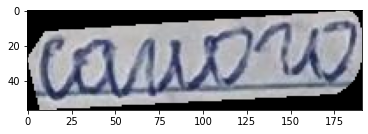

Prediction:  калого
True:  самого


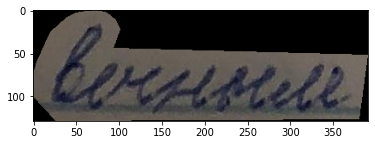

Prediction:  н
True:  вечным


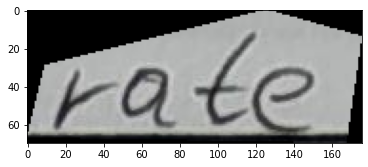

Prediction:  н
True:  rate


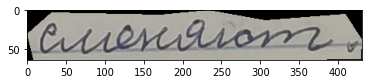

Prediction:  Сменяйт.
True:  сменяют.


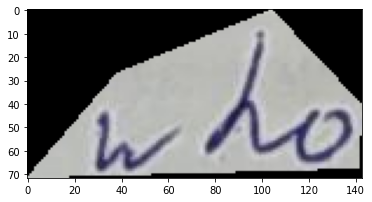

Prediction:  [ло
True:  who


In [41]:
pred_json = {}

# img_path = "../input/tryyyy/data/data/train_recognition/images/0.png"
# img = cv2.imread(img_path)
# pred = predictor(img)

# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img)
# plt.show()

# print('Prediction: ', pred)
# print('True: ', val_img[1])


print_images = True
for val_img in val_data_splitted[20:25]:
    img = cv2.imread(f'/content/drive/MyDrive/data/train_recognition/images/{val_img[0]}')
    
    pred = predictor(img)
    pred_json[val_img[0]] = pred

    if print_images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.show()
        print('Prediction: ', predictor(img))
        print('True: ', val_img[1])


Сохраням submission json с предсказаниями

In [ ]:
with open('prediction_HTR.json', 'w') as f:
    json.dump(pred_json, f)